In this project I explored the Paycheck Protection Program (PPP) and simultaneous changes in national employment levels by industry type from April 2020 to June 2021. After preprocessing the sizeable PPP dataset (11.8 million rows, 50+ columns), I analyzed patterns across 13 different industries in loan features and employment. Industries varied greatly both in numbers of employees and loans received, with no apparent relationship between the two. Most industries received between 750,000 and 2,000,000 loans. The utilities sector stood out because it received the fewest loans overall and the fewest loans per thousand employees, and it grew the least in employment (less than 1%). The following patterns held true for every industry. The most common loans were less than 30,000, and as loan size increased above that, the number of loans decreased. Maximum loan size was 1,000,000 USD. Businesses of one to two employees were by far the most common borrowers, and the majority of businesses had fewer than ten employees. Two sectors, leisure and hospitality and manufacturing, had greater proportions of businesses with 20 or more employees. Employment was lowest early in the study and then grew by 2% to 25% for most sectors, with the notable exception of leisure and hospitality which grew 70%. 

Employment outcomes were aggregated into 13 industries, resulting in a very small set of target values. Nevertheless, I wanted to see whether regression models could predict employment growth using number of loans, loan size, and business size as predictors. Not surprisingly, error was very high (lowest Percent RMSE = 51.07%), indicating that any emerging trends are very tentative. If one were tempted to interpret the models, considered together they suggest that growth in employment may be positively correlated with the number of loans and possibly business size, and be negatively correlated with loan size.

For access to the data files, please see the links in the README file of my GitHub repository where this notebook is stored.

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
from sklearn.metrics import mean_squared_error

Start with employment data. Note that all employment data are in thousands, as provided by the US Bureau of Labor Statistics. Explore how to reshape a csv file into a single column that goes from earliest month to most recent month.

In [2]:
Employ_Total_nonfarm = pd.read_csv("data/Employment/Total_nonfarm.csv")
Employ_Total_nonfarm.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2011,130841,131053,131288,131602,131703,131939,131999.0,132125.0,132358.0,132562.0,132694.0,132896.0
1,2012,133250,133512,133752,133834,133934,134007,134159.0,134331.0,134518.0,134677.0,134833.0,135072.0
2,2013,135263,135541,135680,135871,136093,136274,136386.0,136628.0,136815.0,137040.0,137304.0,137373.0
3,2014,137548,137714,137968,138293,138511,138837,139069.0,139257.0,139566.0,139818.0,140109.0,140377.0
4,2015,140568,140839,140910,141194,141525,141699,142001.0,142126.0,142281.0,142587.0,142824.0,143097.0


Setting the index to "Year" allows me to then use the df.stack() method to stack the data row by row (year by year), which converts the old column labels -- months -- to a new inner-most level of row labels (new level of index).

In [3]:
Employ_Total_nonfarm_indexed = Employ_Total_nonfarm.set_index(["Year"])

In [4]:
Employ_Total_nonfarm_stacked = Employ_Total_nonfarm_indexed.stack()
Employ_Total_nonfarm_stacked.head(26)

Year     
2011  Jan    130841.0
      Feb    131053.0
      Mar    131288.0
      Apr    131602.0
      May    131703.0
      Jun    131939.0
      Jul    131999.0
      Aug    132125.0
      Sep    132358.0
      Oct    132562.0
      Nov    132694.0
      Dec    132896.0
2012  Jan    133250.0
      Feb    133512.0
      Mar    133752.0
      Apr    133834.0
      May    133934.0
      Jun    134007.0
      Jul    134159.0
      Aug    134331.0
      Sep    134518.0
      Oct    134677.0
      Nov    134833.0
      Dec    135072.0
2013  Jan    135263.0
      Feb    135541.0
dtype: float64

Next repeat steps above for another industry's csv file.

In [5]:
Employ_Total_private = pd.read_csv("data/Employment/Total_private.csv")
Employ_Total_private_indexed = Employ_Total_private.set_index(["Year"])
Employ_Total_private_stacked = Employ_Total_private_indexed.stack()
Employ_Total_private_stacked.head()

Year     
2011  Jan    108583.0
      Feb    108838.0
      Mar    109096.0
      Apr    109418.0
      May    109574.0
dtype: float64

Create a new data frame by concatenating the two series (single column data frames) we generated above. Using keys, add column labels and tell pd.concat to concatenate columns by specifiying axis = 1.

In [6]:
employ = [Employ_Total_nonfarm_stacked, Employ_Total_private_stacked]
pd.concat(employ, keys = ["Total_nonfarm", "Total_private"], axis = 1)

Total_nonfarm  Total_private
Year                                  
2011 Jan       130841.0       108583.0
     Feb       131053.0       108838.0
     Mar       131288.0       109096.0
     Apr       131602.0       109418.0
     May       131703.0       109574.0
...                 ...            ...
2021 Feb       143272.0       121791.0
     Mar       144057.0       122515.0
     Apr       144326.0       122741.0
     May       144909.0       123257.0
     Jun       145759.0       123919.0

[126 rows x 2 columns]

That works! Now, to iterate this process and make the code more elegant using a generator. 

In [7]:
industries = ['Total_nonfarm', 'Total_private', 'Mining_and_logging', 'Construction', 'Manufacturing', 'Trade_transportation_and_utilities', 'Wholesale_trade', 'Retail_trade', 'Transportation_and_warehousing', 'Utilities', 'Information', 'Financial_activities', 'Professional_and_business_services', 'Educational_and_health_services', 'Leisure_and_hospitality', 'Other_services', 'Government']

def read_Employment_files(filenames):
    for file in filenames:
        temp_df = pd.read_csv("data/Employment/" + file + ".csv").set_index(["Year"])
        yield temp_df.stack()
    
employment_data = pd.concat(read_Employment_files(industries), keys = industries, axis = 1)

employment_data

Total_nonfarm  Total_private  Mining_and_logging  Construction  \
Year                                                                       
2011 Jan       130841.0       108583.0               736.0        5427.0   
     Feb       131053.0       108838.0               739.0        5451.0   
     Mar       131288.0       109096.0               754.0        5477.0   
     Apr       131602.0       109418.0               768.0        5485.0   
     May       131703.0       109574.0               778.0        5516.0   
...                 ...            ...                 ...           ...   
2021 Feb       143272.0       121791.0               598.0        7355.0   
     Mar       144057.0       122515.0               613.0        7448.0   
     Apr       144326.0       122741.0               616.0        7439.0   
     May       144909.0       123257.0               618.0        7417.0   
     Jun       145759.0       123919.0               630.0        7410.0   

          Manufacturing  Trade_transportation_and_utilities  Wholesale_trade  \
Year                                                                           
2011 Jan        11621.0                             24721.0           5414.8   
     Feb        11654.0                             24787.0           5427.5   
     Mar        11675.0                             24845.0           5443.9   
     Apr        11704.0                             24934.0           5456.7   
     May        11713.0                             24947.0           5462.6   
...                 ...                                 ...              ...   
2021 Feb        12248.0                             27081.0           5639.1   
     Mar        12299.0                             27186.0           5658.0   
     Apr        12264.0                             27116.0           5664.9   
     May        12303.0                             27179.0           5681.5   
     Jun        12318.0                             27278.0           5702.8   

          Retail_trade  Transportation_and_warehousing  Utilities  \
Year                                                                
2011 Jan       14537.1                          4217.3      551.5   
     Feb       14558.2                          4248.2      553.3   
     Mar       14589.2                          4258.7      552.7   
     Apr       14646.2                          4277.4      553.7   
     May       14645.8                          4285.6      553.1   
...                ...                             ...        ...   
2021 Feb       15192.7                          5710.4      539.2   
     Mar       15234.6                          5753.1      539.8   
     Apr       15212.6                          5698.2      540.2   
     May       15239.3                          5718.8      539.3   
     Jun       15306.4                          5729.5      539.3   

          Information  Financial_activities  \
Year                                          
2011 Jan       2678.0                7680.0   
     Feb       2673.0                7676.0   
     Mar       2672.0                7681.0   
     Apr       2674.0                7679.0   
     May       2679.0                7702.0   
...               ...                   ...   
2021 Feb       2678.0                8774.0   
     Mar       2683.0                8787.0   
     Apr       2694.0                8804.0   
     May       2722.0                8801.0   
     Jun       2736.0                8800.0   

          Professional_and_business_services  Educational_and_health_services  \
Year                                                                            
2011 Jan                             17091.0                          20153.0   
     Feb                             17170.0                          20163.0   
     Mar                             17235.0                          20177.0   
     Apr                             17297.0                     

Save df to csv for later use.

In [8]:
employment_data.to_csv("C:\\Users\\fac_dalton\\data\\employment_data.csv")

Before concatenating all PPP data files (predictors), check a representative file to see what columns it has.

In [9]:
df_check = pd.read_csv("data/PPP/public_up_to_150k_1_210630.csv")
cols = df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LoanNumber                   900000 non-null  int64  
 1   DateApproved                 900000 non-null  object 
 2   SBAOfficeCode                899987 non-null  float64
 3   ProcessingMethod             900000 non-null  object 
 4   BorrowerName                 899997 non-null  object 
 5   BorrowerAddress              899871 non-null  object 
 6   BorrowerCity                 899870 non-null  object 
 7   BorrowerState                899860 non-null  object 
 8   BorrowerZip                  899872 non-null  object 
 9   LoanStatusDate               301530 non-null  object 
 10  LoanStatus                   900000 non-null  object 
 11  Term                         900000 non-null  int64  
 12  SBAGuarantyPercentage        900000 non-null  int64  
 13 

Create ndarray of column names in df_check so that in read_PPPfiles function below I can compare same for all csv files to confirm all files have identical columns.

In [10]:
cols = df_check.columns.values

Next read in PPP data. Concatenate csv files into one df using glob.glob to return list of csv filenames in dir. Set dtype=object for columns 16 ('FranchiseName') & 50 ('NonProfit').

In [11]:
PPP_filelist = glob.glob("data/PPP/*.csv")
def read_PPPfiles(filelist):
    for f in filelist:
        file = pd.read_csv(f, dtype={'FranchiseName': object, 'NonProfit': object})
        cols_file = file.columns.values
        if np.array_equal(cols, cols_file):
            yield file
        else:
            print(f + " columns don't match.")
PPP_df = pd.concat(read_PPPfiles(PPP_filelist))
PPP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11768689 entries, 0 to 899999
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   LoanNumber                   int64  
 1   DateApproved                 object 
 2   SBAOfficeCode                float64
 3   ProcessingMethod             object 
 4   BorrowerName                 object 
 5   BorrowerAddress              object 
 6   BorrowerCity                 object 
 7   BorrowerState                object 
 8   BorrowerZip                  object 
 9   LoanStatusDate               object 
 10  LoanStatus                   object 
 11  Term                         int64  
 12  SBAGuarantyPercentage        int64  
 13  InitialApprovalAmount        float64
 14  CurrentApprovalAmount        float64
 15  UndisbursedAmount            float64
 16  FranchiseName                object 
 17  ServicingLenderLocationID    float64
 18  ServicingLenderName          object 
 19  

In [12]:
# Check indexing
PPP_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            899990, 899991, 899992, 899993, 899994, 899995, 899996, 899997,
            899998, 899999],
           dtype='int64', length=11768689)

Final index above is lower than expected from number of rows, so don't have unique sequence of indices. Let's reset them.

In [13]:
PPP_df = PPP_df.reset_index(drop=True)

Confirm that NAICS codes are all 6 digit.

In [14]:
PPP_df.agg({'NAICSCode': ['min', 'max']})

,NAICSCode
min,111110.0
max,999990.0


Map NAICS codes to new column 'Industry_type' according to "industries" in employment dataset, following the mapping analysis below.

Don’t have agriculture employment data, so omit those loan categories

Mining & logging employment data are lumped together. In the NAICS 6-digit coding system, 11 is agriculture, forestry, fishing, & hunting. Codes 1133 and 113310 are logging, so map these to logging & mining which includes 21 (all mining) so include 210000 to 219999 in logging & mining. Omit 110000 through 113299 and 114000 through 119999 to remove the rest of the agriculture sector.

Finance & Insurance 520000 and Real Estate 530000 are lumped together in Financial Activities employment data. So, map 520000 through 539999 to a Financial Activities category.

In the employment data set, “Trade_transportation_and_utilities” is a summary column of “Wholesale_trade”, “Retail_trade”, “Transportation_and_warehousing”, and “Utilities”. Omit this column when concatenating.

The following categories map directly, one to one (expanding from 2 digit to 6 digit codes):
113300-113310 and 21 = “Logging_and _Mining”
drop 110000 - 113299 and 114000 – 119999, which are “Other_agriculture” for which I don’t have employment data.
22 = “Utilities”
23 = “Construction”
31-33 = “Manufacturing”
42 = “Wholesale_trade”
44-45 = “Retail_trade”
48-49 = “Transportation_and_ warehousing”
51 = “Information”
52-53 = “Financial Activities”
54-56 = “Professional_and_business_services”
61-62 = “Educational_and_health_services”
71-72 = “Leisure_and_hospitality”
81 = “Other_services”

In [15]:
industries

['Total_nonfarm',
 'Total_private',
 'Mining_and_logging',
 'Construction',
 'Manufacturing',
 'Trade_transportation_and_utilities',
 'Wholesale_trade',
 'Retail_trade',
 'Transportation_and_warehousing',
 'Utilities',
 'Information',
 'Financial_activities',
 'Professional_and_business_services',
 'Educational_and_health_services',
 'Leisure_and_hospitality',
 'Other_services',
 'Government']

Drop rows with agriculture NAICS codes that don't correspond to logging. If present, drop them because we have employment data for only the logging subcategory of agriculture.

In [16]:
PPP_df.drop(PPP_df[((PPP_df['NAICSCode'] >= 110000) & (PPP_df['NAICSCode'] <= 113299)) | ((PPP_df['NAICSCode'] >= 114000) & (PPP_df['NAICSCode'] <= 119999))].index, inplace = True)

In [17]:
PPP_df.drop(PPP_df[(PPP_df['NAICSCode']>=900000)].index, inplace=True)

In [18]:
PPP_df.shape

(10982605, 53)

Now map NAICS codes to a new column 'Industry_type', expanding from 2 digit to 6 digit NAICS codes:

Drop 110000 - 113299 and 114000 – 119999, which are “Other_agriculture” for which I don’t have employment data.
Also Drop >=9000000 which is Government (Public Administration)
113300-113310 and 21 = “Logging_and _Mining”; 22 = “Utilities”; 23 = “Construction”; 31-33 = “Manufacturing”; 42 = “Wholesale_trade”; 44-45 = “Retail_trade”; 48-49 = “Transportation_and_warehousing”; 51 = “Information”; 
52-53 = “Financial_activities”; 54-56 = “Professional_and_business_services”; 61-62 = “Educational_and_health_services”; 
71-72 = “Leisure_and_hospitality”; 81 = “Other_services”

Include only rows with a NAICS code.

In [19]:
PPP_df = PPP_df[PPP_df['NAICSCode'].notna()]

First confirm that there are no codes between 113399 and 210000, which would also be "Other_agriculture" that is not logging. Using np.logical_and allows two conditions to be used in np.where.

In [20]:
logmine = np.where(np.logical_and(PPP_df['NAICSCode'] >= 113300, PPP_df['NAICSCode'] <= 113399), 1000000, PPP_df['NAICSCode'])
print('Logging_and_mining minimum = {} and maximumm = {}'.format(logmine.min(), logmine.max()))

Logging_and_mining minimum = 211111.0 and maximumm = 1000000.0


In [21]:
PPP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10850202 entries, 0 to 11768688
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   LoanNumber                   int64  
 1   DateApproved                 object 
 2   SBAOfficeCode                float64
 3   ProcessingMethod             object 
 4   BorrowerName                 object 
 5   BorrowerAddress              object 
 6   BorrowerCity                 object 
 7   BorrowerState                object 
 8   BorrowerZip                  object 
 9   LoanStatusDate               object 
 10  LoanStatus                   object 
 11  Term                         int64  
 12  SBAGuarantyPercentage        int64  
 13  InitialApprovalAmount        float64
 14  CurrentApprovalAmount        float64
 15  UndisbursedAmount            float64
 16  FranchiseName                object 
 17  ServicingLenderLocationID    float64
 18  ServicingLenderName          object 
 19

Use np.select(condlist, choicelist) to map NAICS code ranges in condlist ('NAICS_groups') to their corresponding indidustries.

In [22]:
NAICS_groups = [PPP_df['NAICSCode'].between(0, 113399), PPP_df['NAICSCode'].between(210000, 219999), PPP_df['NAICSCode'].between(220000, 229999), PPP_df['NAICSCode'].between(230000, 239999), PPP_df['NAICSCode'].between(310000, 339999), PPP_df['NAICSCode'].between(420000, 429999), PPP_df['NAICSCode'].between(440000, 459999), PPP_df['NAICSCode'].between(480000, 499999), PPP_df['NAICSCode'].between(510000, 519999), PPP_df['NAICSCode'].between(520000, 539999), PPP_df['NAICSCode'].between(540000, 569999), PPP_df['NAICSCode'].between(610000, 629999), PPP_df['NAICSCode'].between(710000, 729999), PPP_df['NAICSCode'].between(810000, 819999)]
values = ['Mining_and_logging', 'Mining_and_logging', 'Utilities', 'Construction', 'Manufacturing', 'Wholesale_trade', 'Retail_trade', 'Transportation_and_warehousing', 'Information', 'Financial_activities', 'Professional_and_business_services', 'Educational_and_health_services', 'Leisure_and_hospitality', 'Other_services']
PPP_df['Industry_Type'] = np.select(NAICS_groups, values)
PPP_df.head()

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate,Industry_Type
0,9547507704,05/01/2020,464.0,PPP,"SUMTER COATINGS, INC.",2410 Highway 15 South,Sumter,NaN,29150-9662,12/18/2020,...,19248.0,Synovus Bank,COLUMBUS,GA,Unanswered,Unanswered,NaN,773553.37,11/20/2020,Manufacturing
1,9777677704,05/01/2020,464.0,PPP,"PLEASANT PLACES, INC.",7684 Southrail Road,North Charleston,NaN,29420-9000,NaN,...,19248.0,Synovus Bank,COLUMBUS,GA,Male Owned,Non-Veteran,NaN,NaN,NaN,Professional_and_business_services
3,6223567700,05/01/2020,920.0,PPP,KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,NaN,92407-1740,NaN,...,9551.0,"Bank of America, National Association",CHARLOTTE,NC,Unanswered,Unanswered,NaN,NaN,NaN,Construction
4,9662437702,05/01/2020,101.0,PPP,AERO BOX LLC,NaN,NaN,NaN,NaN,NaN,...,57328.0,The Huntington National Bank,COLUMBUS,OH,Unanswered,Unanswered,NaN,370819.35,04/08/2021,Transportation_and_warehousing
5,9774337701,05/01/2020,101.0,PPP,HUDSON EXTRUSIONS INC.,NaN,NaN,NaN,NaN,NaN,...,57328.0,The Huntington National Bank,COLUMBUS,OH,Unanswered,Unanswered,NaN,332137.41,05/10/2021,Manufacturing


Drop employment rows before pandemic. First reset index to more easily select rows to delete. This will convert old index levels ('Year' and month) to columns.

In [23]:
employment_data.reset_index(inplace=True)

In [24]:
employment_data.drop(employment_data.loc[0:110].index, inplace=True)

In [25]:
employment_data

,Year,level_1,Total_nonfarm,Total_private,Mining_and_logging,Construction,Manufacturing,Trade_transportation_and_utilities,Wholesale_trade,Retail_trade,Transportation_and_warehousing,Utilities,Information,Financial_activities,Professional_and_business_services,Educational_and_health_services,Leisure_and_hospitality,Other_services,Government
111,2020,Apr,130161.0,108335.0,622.0,6535.0,11414.0,24513.0,5486.0,13235.3,5248.5,543.5,2633.0,8596.0,19082.0,21722.0,8691.0,4527.0,21826.0
112,2020,May,132994.0,111680.0,601.0,7004.0,11657.0,24934.0,5508.6,13644.1,5239.0,542.0,2594.0,8613.0,19247.0,22107.0,10146.0,4777.0,21314.0
113,2020,Jun,137840.0,116487.0,597.0,7171.0,11999.0,25934.0,5556.9,14502.8,5335.7,539.0,2602.0,8634.0,19568.0,22671.0,12158.0,5153.0,21353.0
114,2020,Jul,139566.0,118010.0,593.0,7197.0,12037.0,26205.0,5537.4,14742.9,5385.2,539.5,2592.0,8646.0,19715.0,22885.0,12824.0,5316.0,21556.0
115,2020,Aug,141149.0,119076.0,589.0,7223.0,12068.0,26553.0,5544.5,14995.8,5472.4,539.9,2617.0,8674.0,19915.0,23084.0,12963.0,5390.0,22073.0
116,2020,Sep,141865.0,120008.0,592.0,7256.0,12123.0,26662.0,5578.4,15025.3,5516.4,541.6,2659.0,8712.0,20055.0,23152.0,13357.0,5440.0,21857.0
117,2020,Oct,142545.0,120962.0,594.0,7329.0,12155.0,26847.0,5587.6,15131.8,5587.7,540.1,2650.0,8746.0,20296.0,23235.0,13622.0,5488.0,21583.0
118,2020,Nov,142809.0,121321.0,597.0,7353.0,12196.0,26983.0,5602.4,15129.7,5711.3,539.5,2650.0,8756.0,20391.0,23278.0,13632.0,5485.0,21488.0
119,2020,Dec,142503.0,121047.0,597.0,7400.0,12231.0,26984.0,5617.2,15159.8,5668.1,538.5,2659.0,8774.0,20550.0,23249.0,13134.0,5469.0,21456.0
120,2021,Jan,142736.0,121169.0,596.0,7412.0,12213.0,27023.0,5631.4,15178.3,5674.0,539.4,2672.0,8781.0,20640.0,23235.0,13117.0,5480.0,21567.0


In [26]:
employment_data.rename(columns={employment_data.columns[1]: 'Month'}, inplace=True)
# drop aggregating columns included in original dataset.
employment_data.drop(labels=['Total_nonfarm', 'Total_private', 'Government', 'Trade_transportation_and_utilities'], inplace=True, axis = 1)
employment_data

,Year,Month,Mining_and_logging,Construction,Manufacturing,Wholesale_trade,Retail_trade,Transportation_and_warehousing,Utilities,Information,Financial_activities,Professional_and_business_services,Educational_and_health_services,Leisure_and_hospitality,Other_services
111,2020,Apr,622.0,6535.0,11414.0,5486.0,13235.3,5248.5,543.5,2633.0,8596.0,19082.0,21722.0,8691.0,4527.0
112,2020,May,601.0,7004.0,11657.0,5508.6,13644.1,5239.0,542.0,2594.0,8613.0,19247.0,22107.0,10146.0,4777.0
113,2020,Jun,597.0,7171.0,11999.0,5556.9,14502.8,5335.7,539.0,2602.0,8634.0,19568.0,22671.0,12158.0,5153.0
114,2020,Jul,593.0,7197.0,12037.0,5537.4,14742.9,5385.2,539.5,2592.0,8646.0,19715.0,22885.0,12824.0,5316.0
115,2020,Aug,589.0,7223.0,12068.0,5544.5,14995.8,5472.4,539.9,2617.0,8674.0,19915.0,23084.0,12963.0,5390.0
116,2020,Sep,592.0,7256.0,12123.0,5578.4,15025.3,5516.4,541.6,2659.0,8712.0,20055.0,23152.0,13357.0,5440.0
117,2020,Oct,594.0,7329.0,12155.0,5587.6,15131.8,5587.7,540.1,2650.0,8746.0,20296.0,23235.0,13622.0,5488.0
118,2020,Nov,597.0,7353.0,12196.0,5602.4,15129.7,5711.3,539.5,2650.0,8756.0,20391.0,23278.0,13632.0,5485.0
119,2020,Dec,597.0,7400.0,12231.0,5617.2,15159.8,5668.1,538.5,2659.0,8774.0,20550.0,23249.0,13134.0,5469.0
120,2021,Jan,596.0,7412.0,12213.0,5631.4,15178.3,5674.0,539.4,2672.0,8781.0,20640.0,23235.0,13117.0,5480.0


In [27]:
# Restore multiindex with 'Year' and 'Month'.
employment_data.set_index(['Year', 'Month'], inplace=True)
employment_data

Mining_and_logging  Construction  Manufacturing  Wholesale_trade  \
Year Month                                                                     
2020 Apr                 622.0        6535.0        11414.0           5486.0   
     May                 601.0        7004.0        11657.0           5508.6   
     Jun                 597.0        7171.0        11999.0           5556.9   
     Jul                 593.0        7197.0        12037.0           5537.4   
     Aug                 589.0        7223.0        12068.0           5544.5   
     Sep                 592.0        7256.0        12123.0           5578.4   
     Oct                 594.0        7329.0        12155.0           5587.6   
     Nov                 597.0        7353.0        12196.0           5602.4   
     Dec                 597.0        7400.0        12231.0           5617.2   
2021 Jan                 596.0        7412.0        12213.0           5631.4   
     Feb                 598.0        7355.0        12248.0           5639.1   
     Mar                 613.0        7448.0        12299.0           5658.0   
     Apr                 616.0        7439.0        12264.0           5664.9   
     May                 618.0        7417.0        12303.0           5681.5   
     Jun                 630.0        7410.0        12318.0           5702.8   

            Retail_trade  Transportation_and_warehousing  Utilities  \
Year Month                                                            
2020 Apr         13235.3                          5248.5      543.5   
     May         13644.1                          5239.0      542.0   
     Jun         14502.8                          5335.7      539.0   
     Jul         14742.9                          5385.2      539.5   
     Aug         14995.8                          5472.4      539.9   
     Sep         15025.3                          5516.4      541.6   
     Oct         15131.8                          5587.7      540.1   
     Nov         15129.7                          5711.3      539.5   
     Dec         15159.8                          5668.1      538.5   
2021 Jan         15178.3                          5674.0      539.4   
     Feb         15192.7                          5710.4      539.2   
     Mar         15234.6                          5753.1      539.8   
     Apr         15212.6                          5698.2      540.2   
     May         15239.3                          5718.8      539.3   
     Jun         15306.4                          5729.5      539.3   

            Information  Financial_activities  \
Year Month                                      
2020 Apr         2633.0                8596.0   
     May         2594.0                8613.0   
     Jun         2602.0                8634.0   
     Jul         2592.0                8646.0   
     Aug         2617.0                8674.0   
     Sep         2659.0                8712.0   
     Oct         2650.0                8746.0   
     Nov         2650.0                8756.0   
     Dec         2659.0                8774.0   
2021 Jan         2672.0                8781.0   
     Feb         2678.0                8774.0   
     Mar         2683.0                8787.0   
     Apr         2694.0                8804.0   
     May         2722.0                8801.0   
     Jun         2736.0                8800.0   

            Professional_and_business_services  \
Year Month                                       
2020 Apr                               19082.0   
     May                               19247.0   
     Jun                               19568.0   
     Jul                               19715.0   
     Aug                               19915.0   
     Sep                               20055.0   
     Oct                               20296.0   
     Nov                               20391.0   
     Dec                               20550.0   
2021 Jan                               20640.0   
     Feb 

In [28]:
# Find minimum employement during covid for each industry.
employ_min = employment_data.min()
employ_min

Mining_and_logging                      589.0
Construction                           6535.0
Manufacturing                         11414.0
Wholesale_trade                        5486.0
Retail_trade                          13235.3
Transportation_and_warehousing         5239.0
Utilities                               538.5
Information                            2592.0
Financial_activities                   8596.0
Professional_and_business_services    19082.0
Educational_and_health_services       21722.0
Leisure_and_hospitality                8691.0
Other_services                         4527.0
dtype: float64

In [29]:
employ_start = employment_data.loc[(2020, 'Apr')]
employ_start

Mining_and_logging                      622.0
Construction                           6535.0
Manufacturing                         11414.0
Wholesale_trade                        5486.0
Retail_trade                          13235.3
Transportation_and_warehousing         5248.5
Utilities                               543.5
Information                            2633.0
Financial_activities                   8596.0
Professional_and_business_services    19082.0
Educational_and_health_services       21722.0
Leisure_and_hospitality                8691.0
Other_services                         4527.0
Name: (2020, Apr), dtype: float64

In [30]:
# Select the final employment record (6/2021) for each industry.
employ_end = employment_data.loc[(2021, 'Jun')]
employ_end

Mining_and_logging                      630.0
Construction                           7410.0
Manufacturing                         12318.0
Wholesale_trade                        5702.8
Retail_trade                          15306.4
Transportation_and_warehousing         5729.5
Utilities                               539.3
Information                            2736.0
Financial_activities                   8800.0
Professional_and_business_services    20836.0
Educational_and_health_services       23537.0
Leisure_and_hospitality               14734.0
Other_services                         5640.0
Name: (2021, Jun), dtype: float64

In [31]:
# Create new column 'change' that shows difference between minimum and ending employment ('6/2021'). Sort by 'Industry'. 
employ_change = pd.concat([employ_start, employ_end, employ_min], axis = 1)
employ_change.sort_index(inplace=True)
employ_change.columns = ['Empl_4_2020', "Empl_6_2021", "Empl_min"]
employ_change["Empl_change"] = (employ_change['Empl_6_2021'] - employ_change['Empl_min'])
employ_change

,Empl_4_2020,Empl_6_2021,Empl_min,Empl_change
Construction,6535.0,7410.0,6535.0,875.0
Educational_and_health_services,21722.0,23537.0,21722.0,1815.0
Financial_activities,8596.0,8800.0,8596.0,204.0
Information,2633.0,2736.0,2592.0,144.0
Leisure_and_hospitality,8691.0,14734.0,8691.0,6043.0
Manufacturing,11414.0,12318.0,11414.0,904.0
Mining_and_logging,622.0,630.0,589.0,41.0
Other_services,4527.0,5640.0,4527.0,1113.0
Professional_and_business_services,19082.0,20836.0,19082.0,1754.0
Retail_trade,13235.3,15306.4,13235.3,2071.1


In [32]:
# Omitted some rows, so reset index
PPP_df = PPP_df.reset_index(drop=True)

Determine mean loan size, number of loans, and mean business size (number of employees) by industry.

In [33]:
# Make sorted list of industries for use in graphs.
industry_list = PPP_df['Industry_Type'].unique().tolist()
industry_list.sort()
industry_list

['Construction',
 'Educational_and_health_services',
 'Financial_activities',
 'Information',
 'Leisure_and_hospitality',
 'Manufacturing',
 'Mining_and_logging',
 'Other_services',
 'Professional_and_business_services',
 'Retail_trade',
 'Transportation_and_warehousing',
 'Utilities',
 'Wholesale_trade']

In [34]:
# Examine loan size data
PPP_df['CurrentApprovalAmount'].describe()

count    1.085020e+07
mean     7.087991e+04
std      2.626986e+05
min      0.000000e+00
25%      9.800000e+03
50%      2.070000e+04
75%      4.166500e+04
max      1.000000e+07
Name: CurrentApprovalAmount, dtype: float64

In [35]:
# How many rows have 0 for loan amount?
len(PPP_df[PPP_df['CurrentApprovalAmount'] == 0].index)

3

In [36]:
# Delete rows where loan amount is 0. 
PPP_df.drop(PPP_df[PPP_df['CurrentApprovalAmount'] == 0].index, inplace = True)

In [37]:
# Examine distribution of loan size by industry.
PPP_df[['CurrentApprovalAmount', 'Industry_Type']].groupby('Industry_Type').describe()

CurrentApprovalAmount                 \
                                                   count           mean   
Industry_Type                                                             
Construction                                   1045240.0   93919.075200   
Educational_and_health_services                1197841.0   94675.776226   
Financial_activities                            825441.0   46404.349968   
Information                                     147298.0   90699.513983   
Leisure_and_hospitality                        1189274.0   83551.752811   
Manufacturing                                   455605.0  166742.611738   
Mining_and_logging                               56385.0  133692.509737   
Other_services                                 1667397.0   35091.639560   
Professional_and_business_services             1984950.0   68610.680798   
Retail_trade                                    929404.0   59738.690285   
Transportation_and_warehousing                  978624.0   33683.040893   
Utilities                                        14061.0  134636.396778   
Wholesale_trade                                 358679.0  105587.379964   

                                                                              \
                                              std    min       25%       50%   
Industry_Type                                                                  
Construction                        309657.041287   1.00  11250.00  20833.00   
Educational_and_health_services     322695.783642  20.00  12500.00  21137.50   
Financial_activities                188659.458280   1.54   9375.00  19714.00   
Information                         340913.523720  40.00   9700.00  20800.00   
Leisure_and_hospitality             260605.205821   1.88  13700.00  21875.00   
Manufacturing                       462202.942202   1.00  15417.00  32290.00   
Mining_and_logging                  460133.071791  87.00  13900.00  20833.32   
Other_services                      132290.040188   0.01   7476.65  18680.00   
Professional_and_business_services  266547.284636   1.05   9600.00  20550.00   
Retail_trade                        206772.907060   1.00   9665.00  20300.00   
Transportation_and_warehousing      162503.551112   1.00   6250.00  14405.00   
Utilities                           418494.596945  98.00  14205.00  25300.00   
Wholesale_trade                     327810.589523  50.00  13455.00  20833.00   

                                                             
                                            75%         max  
Industry_Type                                                
Construction                         60973.9275  10000000.0  
Educational_and_health_services      70290.0000  10000000.0  
Financial_activities                 25905.0000  10000000.0  
Information                          50000.0000  10000000.0  
Leisure_and_hospitality              70100.0000  10000000.0  
Manufacturing                       127200.0000  10000000.0  
Mining_and_logging                   81842.0000  10000000.0  
Other_services                       20833.0000  10000000.0  
Professional_and_business_services   37684.0000  10000000.0  
Retail_trade                         36600.1375  10000000.0  
Transportation_and_warehousing       20833.0000  10000000.0  
Utilities                            89386.8700  10000000.0  
Wholesale_trade                      71400.0000  10000000.0

In [38]:
# Calculate mean loan size by industry.
PPP_loan_size = PPP_df['CurrentApprovalAmount'].groupby([PPP_df['Industry_Type']]).mean()
PPP_loan_size.sort_index(inplace=True)
PPP_by_ind = pd.DataFrame(PPP_loan_size)
PPP_by_ind.columns = ['Mean_loan_amount']
PPP_by_ind

,Mean_loan_amount
Industry_Type,
Construction,93919.075200
Educational_and_health_services,94675.776226
Financial_activities,46404.349968
Information,90699.513983
Leisure_and_hospitality,83551.752811
Manufacturing,166742.611738
Mining_and_logging,133692.509737
Other_services,35091.639560
Professional_and_business_services,68610.680798


In [39]:
PPP_biz_size = PPP_df['JobsReported'].groupby(PPP_df['Industry_Type']).mean()

In [40]:
# Verify that each row has a unique loan number, indicating that each row is a unique loan.
print('PPP_df has {} rows and {} unique loan numbers'.format(len(PPP_df.index), len(PPP_df['LoanNumber'].unique())))

PPP_df has 10850199 rows and 10850199 unique loan numbers


In [41]:
# Count number of loans, grouped by industry.
PPP_loan_count = PPP_df.groupby('Industry_Type').size()
PPP_loan_count

Industry_Type
Construction                          1045240
Educational_and_health_services       1197841
Financial_activities                   825441
Information                            147298
Leisure_and_hospitality               1189274
Manufacturing                          455605
Mining_and_logging                      56385
Other_services                        1667397
Professional_and_business_services    1984950
Retail_trade                           929404
Transportation_and_warehousing         978624
Utilities                               14061
Wholesale_trade                        358679
dtype: int64

In [42]:
# Concatenate columns.
Industry_grouped = pd.concat([PPP_by_ind, PPP_loan_count, PPP_biz_size, employ_change], axis=1).astype('float')
Industry_grouped = Industry_grouped.rename(columns = {Industry_grouped.columns[1]: 'Number_of_loans'})
Industry_grouped

,Mean_loan_amount,Number_of_loans,JobsReported,Empl_4_2020,Empl_6_2021,Empl_min,Empl_change
Construction,93919.075200,1045240.0,8.104037,6535.0,7410.0,6535.0,875.0
Educational_and_health_services,94675.776226,1197841.0,11.745201,21722.0,23537.0,21722.0,1815.0
Financial_activities,46404.349968,825441.0,4.374639,8596.0,8800.0,8596.0,204.0
Information,90699.513983,147298.0,7.847717,2633.0,2736.0,2592.0,144.0
Leisure_and_hospitality,83551.752811,1189274.0,14.091540,8691.0,14734.0,8691.0,6043.0
Manufacturing,166742.611738,455605.0,15.531477,11414.0,12318.0,11414.0,904.0
Mining_and_logging,133692.509737,56385.0,9.642086,622.0,630.0,589.0,41.0
Other_services,35091.639560,1667397.0,4.442999,4527.0,5640.0,4527.0,1113.0
Professional_and_business_services,68610.680798,1984950.0,6.454988,19082.0,20836.0,19082.0,1754.0
Retail_trade,59738.690285,929404.0,7.569503,13235.3,15306.4,13235.3,2071.1


In [43]:
Industry_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, Construction to Wholesale_trade
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mean_loan_amount  13 non-null     float64
 1   Number_of_loans   13 non-null     float64
 2   JobsReported      13 non-null     float64
 3   Empl_4_2020       13 non-null     float64
 4   Empl_6_2021       13 non-null     float64
 5   Empl_min          13 non-null     float64
 6   Empl_change       13 non-null     float64
dtypes: float64(7)
memory usage: 832.0+ bytes


Text(0, 0.5, 'Number of Loans (millions)')

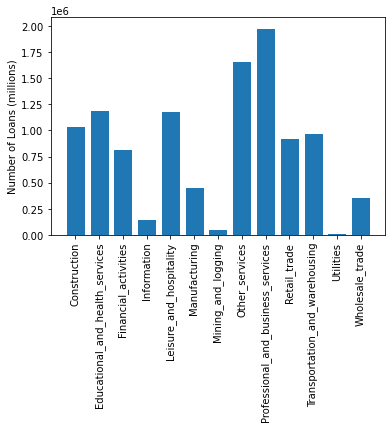

In [44]:
plt.bar(industry_list, PPP_loan_count, edgecolor = 'white')
plt.xticks(rotation=90)
plt.ylabel('Number of Loans (millions)')

Because Empl_change and Number_of_loans may both correlate with the size of the industry, I now scale both by employment level in 4/2020. I will run both the unscaled and scaled data through the models.

In [45]:
Industry_grouped['%_empl_change'] = (Industry_grouped['Empl_change'] / Industry_grouped['Empl_4_2020']) * 100
Industry_grouped['Number_of_loans_rel'] = (Industry_grouped['Number_of_loans'] / Industry_grouped['Empl_4_2020'])
Industry_grouped = Industry_grouped.iloc[:, [0, 1, 8, 2, 3, 4, 5, 6, 7]]
Industry_grouped

,Mean_loan_amount,Number_of_loans,Number_of_loans_rel,JobsReported,Empl_4_2020,Empl_6_2021,Empl_min,Empl_change,%_empl_change
Construction,93919.075200,1045240.0,159.944912,8.104037,6535.0,7410.0,6535.0,875.0,13.389441
Educational_and_health_services,94675.776226,1197841.0,55.144140,11.745201,21722.0,23537.0,21722.0,1815.0,8.355584
Financial_activities,46404.349968,825441.0,96.026175,4.374639,8596.0,8800.0,8596.0,204.0,2.373197
Information,90699.513983,147298.0,55.943031,7.847717,2633.0,2736.0,2592.0,144.0,5.469047
Leisure_and_hospitality,83551.752811,1189274.0,136.839719,14.091540,8691.0,14734.0,8691.0,6043.0,69.531699
Manufacturing,166742.611738,455605.0,39.916331,15.531477,11414.0,12318.0,11414.0,904.0,7.920098
Mining_and_logging,133692.509737,56385.0,90.651125,9.642086,622.0,630.0,589.0,41.0,6.591640
Other_services,35091.639560,1667397.0,368.322730,4.442999,4527.0,5640.0,4527.0,1113.0,24.585818
Professional_and_business_services,68610.680798,1984950.0,104.022115,6.454988,19082.0,20836.0,19082.0,1754.0,9.191909
Retail_trade,59738.690285,929404.0,70.221604,7.569503,13235.3,15306.4,13235.3,2071.1,15.648304


In [46]:
Industry_grouped.to_csv("C:\\Users\\fac_dalton\\data\\Industry_grouped.csv")

For each industry, most loans were less than 130,000 and the maximum was 1,000,000.

Text(0.5, 1.0, 'This plot intentionally blank')

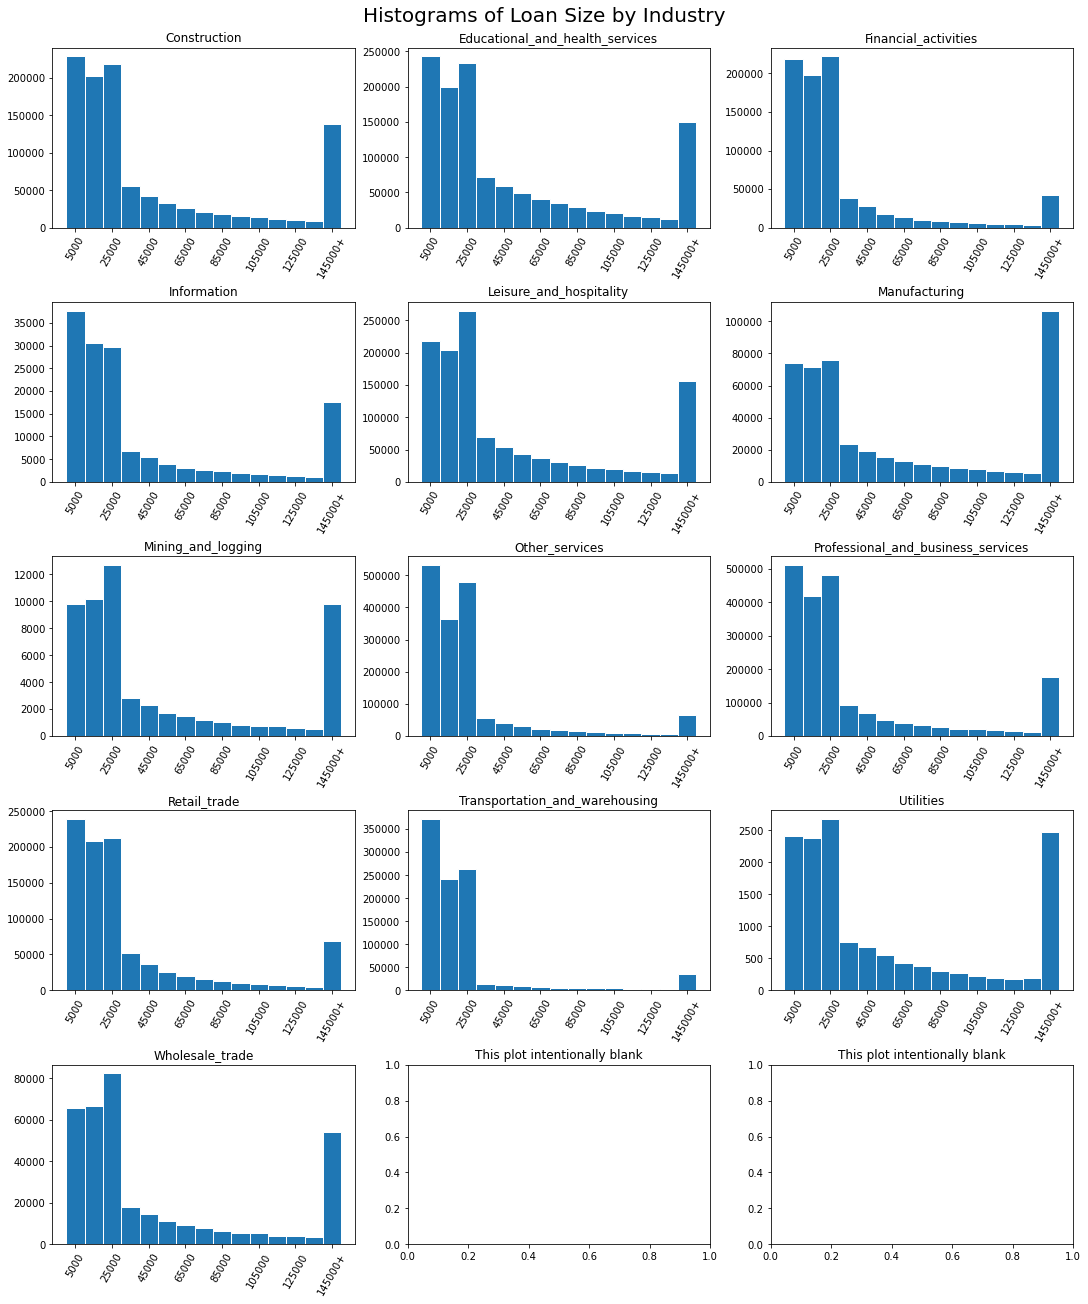

In [47]:
# Plot histograms of loan size by industry.
bins_list = 10000 *np.arange(0, 16, 1)
xlabels = np.arange(5000, 150000, 20000).astype(str)
xlabels[-1] += '+'
x_labels = xlabels.tolist()
x_labels
tick_loc = np.arange(5000, 150000, 20000).tolist()

fig, ax = plt.subplots(5, 3, figsize=(15, 18), constrained_layout = True)
fig.suptitle('Histograms of Loan Size by Industry', fontsize = 20)
# Use loop to generate first 4 rows of plots
for i in range(0, 4):
    for j in range(0, 3):
        index = 3*i+j
        industry = industry_list[index]
        jobs = PPP_df.loc[PPP_df['Industry_Type'] == industry, 'CurrentApprovalAmount']
        ax[i, j].hist([np.clip(jobs, None, bins_list[-1])], bins = bins_list, edgecolor = 'white')
        ax[i, j].set_title(industry)     
        ax[i, j].set_xticks(tick_loc)
        ax[i, j].set_xticklabels(x_labels)
        ax[i, j].tick_params(axis = 'x', labelrotation = 60)
# Generate remaining plot
wholesale_jobs = PPP_df.loc[PPP_df['Industry_Type'] == 'Wholesale_trade', 'CurrentApprovalAmount']
ax[4, 0].hist([np.clip(wholesale_jobs, None, bins_list[-1])], bins = bins_list, edgecolor = 'white')
ax[4, 0].set_title('Wholesale_trade')
ax[4, 0].set_xticks(tick_loc)
ax[4, 0].set_xticklabels(x_labels)
ax[4, 0].tick_params(axis = 'x', labelrotation = 60)
ax[4, 1].set_title('This plot intentionally blank')
ax[4, 2].set_title('This plot intentionally blank')

The analysis above shows similar patterns of loan size across industries, even though the number of loans varied substantially. While the maximum loan size was 1,000,000 for every industry, the most common loan sizes were less than 30,000, and above that the number of loans diminished as loan amount increased. 

Most industries received between 750,000 and 2,000,000 loans, while Information, Mining_and_logging, and Utilities received far fewer loans. However, industries vary greatly in number of employees. How does that relate to number of loans?

Text(0.5, 0, 'Employees in Industry (thousands)')

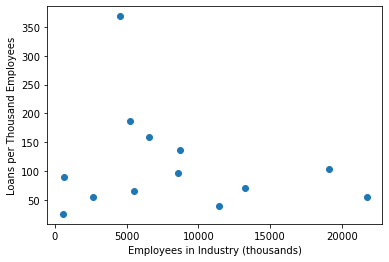

In [48]:
plt.scatter(Industry_grouped['Empl_4_2020'], Industry_grouped['Number_of_loans_rel'])
plt.ylabel('Loans per Thousand Employees')
plt.xlabel('Employees in Industry (thousands)')

There doesn't appear to be a relationship between the number of employees in an industry and the number of loans it received. Let's take another look at number of loans by industry, adjusting for number of employees.

Text(0, 0.5, 'Loans per Thousand Employees')

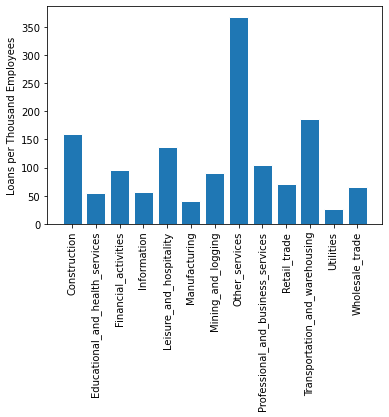

In [49]:
plt.bar(industry_list, Industry_grouped['Number_of_loans_rel'], edgecolor = 'white')
plt.xticks(rotation=90)
plt.ylabel('Loans per Thousand Employees')

Next I explore business size (borrower's number of employees).

In [50]:
# Examine distribution of business size across entire dataset.
PPP_df['JobsReported'].describe()

count    1.085019e+07
mean     7.917354e+00
std      2.515361e+01
min     -6.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      6.000000e+00
max      5.000000e+02
Name: JobsReported, dtype: float64

In [51]:
# How many rows have negative jobs reported?
len(PPP_df[(PPP_df['JobsReported']<1)].index)

156

In [52]:
# JobsReported is the number of employees in the business, so delete those < 1.
PPP_df.drop(PPP_df[PPP_df['JobsReported'] < 1].index, inplace = True)

In [53]:
PPP_df[['Industry_Type', 'JobsReported']].groupby('Industry_Type').describe()

JobsReported                             \
                                          count       mean        std  min   
Industry_Type                                                                
Construction                          1045217.0   8.104214  21.907444  1.0   
Educational_and_health_services       1197830.0  11.745309  34.318950  1.0   
Financial_activities                   825421.0   4.374745  16.393287  1.0   
Information                            147295.0   7.847877  25.903872  1.0   
Leisure_and_hospitality               1189267.0  14.091611  34.184147  1.0   
Manufacturing                          455597.0  15.531716  37.610724  1.0   
Mining_and_logging                      56385.0   9.642086  27.052209  1.0   
Other_services                        1667368.0   4.443073  15.460988  1.0   
Professional_and_business_services    1984909.0   6.455122  23.213074  1.0   
Retail_trade                           929397.0   7.569543  21.581143  1.0   
Transportation_and_warehousing         978614.0   3.428197  15.427587  1.0   
Utilities                               14058.0  10.563167  26.665052  1.0   
Wholesale_trade                        358678.0   9.647071  27.296726  1.0   

                                                           
                                    25%  50%   75%    max  
Industry_Type                                              
Construction                        1.0  2.0   7.0  500.0  
Educational_and_health_services     1.0  3.0   9.0  500.0  
Financial_activities                1.0  1.0   3.0  500.0  
Information                         1.0  2.0   5.0  500.0  
Leisure_and_hospitality             1.0  5.0  14.0  500.0  
Manufacturing                       1.0  4.0  13.0  500.0  
Mining_and_logging                  1.0  2.0   8.0  500.0  
Other_services                      1.0  1.0   3.0  500.0  
Professional_and_business_services  1.0  1.0   4.0  500.0  
Retail_trade                        1.0  2.0   6.0  500.0  
Transportation_and_warehousing      1.0  1.0   1.0  500.0  
Utilities                           1.0  3.0   9.0  500.0  
Wholesale_trade                     1.0  2.0   8.0  500.0

In [54]:
len(PPP_df[(PPP_df['JobsReported']<1)].index)

0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Manufacturing'),
  Text(1, 0, 'Professional_and_business_services'),
  Text(2, 0, 'Construction'),
  Text(3, 0, 'Transportation_and_warehousing'),
  Text(4, 0, 'Other_services'),
  Text(5, 0, 'Wholesale_trade'),
  Text(6, 0, 'Retail_trade'),
  Text(7, 0, 'Leisure_and_hospitality'),
  Text(8, 0, 'Educational_and_health_services'),
  Text(9, 0, 'Information'),
  Text(10, 0, 'Mining_and_logging'),
  Text(11, 0, 'Utilities'),
  Text(12, 0, 'Financial_activities')])

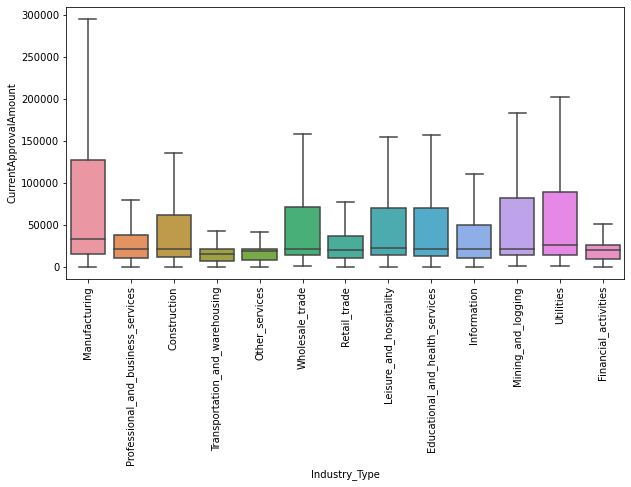

In [55]:
dims = (10, 5)
fig, ax = pyplot.subplots(figsize=dims)
ax = sns.boxplot(x=PPP_df['Industry_Type'], y=PPP_df['CurrentApprovalAmount'], showfliers=False)
plt.xticks(rotation=90)

Text(0.5, 1.0, 'This plot intentionally blank')

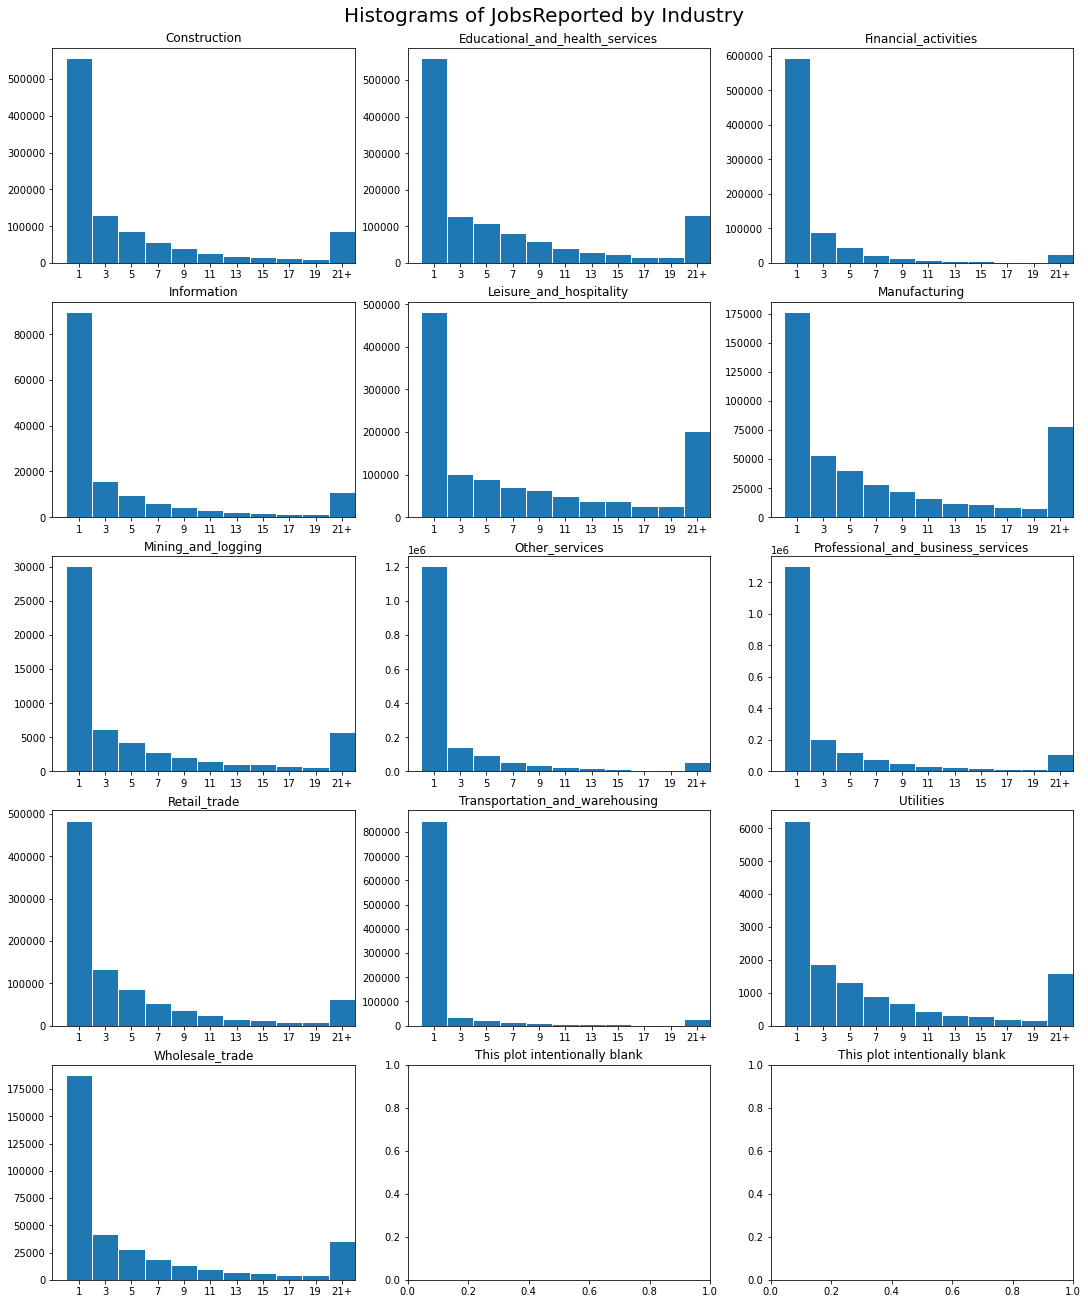

In [56]:
bins_list = np.arange(1, 24, 2)
xlabels = bins_list[:-1].astype(str)
xlabels[-1] += '+'
x_labels = xlabels.tolist()
x_labels
tick_loc = np.arange(2, 23, 2).tolist()

fig, ax = plt.subplots(5, 3, figsize=(15, 18), constrained_layout = True)
fig.suptitle('Histograms of JobsReported by Industry', fontsize = 20)
# Use loop to generate first 4 rows of plots
for i in range(0, 4):
    for j in range(0, 3):
        index = 3*i+j
        industry = industry_list[index]
        jobs = PPP_df.loc[PPP_df['Industry_Type'] == industry, 'JobsReported']
        ax[i, j].hist([np.clip(jobs, None, bins_list[-1])], bins = bins_list, edgecolor = 'white')
        ax[i, j].set_title(industry)     
        ax[i, j].set_xlim(0, 23)
        ax[i, j].set_xticks(tick_loc)
        ax[i, j].set_xticklabels(x_labels)
        
# Generate remaining plot
wholesale_jobs = PPP_df.loc[PPP_df['Industry_Type'] == 'Wholesale_trade', 'JobsReported']
ax[4, 0].hist([np.clip(wholesale_jobs, None, bins_list[-1])], bins = bins_list, edgecolor = 'white')
ax[4, 0].set_title('Wholesale_trade')
ax[4, 0].set_xlim(0, 23)
ax[4, 0].set_xticks(tick_loc)
ax[4, 0].set_xticklabels(x_labels)
ax[4, 1].set_title('This plot intentionally blank')
ax[4, 2].set_title('This plot intentionally blank')

The histograms above show that across all industries, businesses of one to two employees were by far the most common, and the majority of businesses had fewer than ten employees. Leisure_and_hospitality and Manufacturing had the greatest proportion of businesses with 20 or more employees.

Although I have only 13 industries, next I will see if I can train a regression model to predict employment by industry based on number of loans, loan size, and business size.

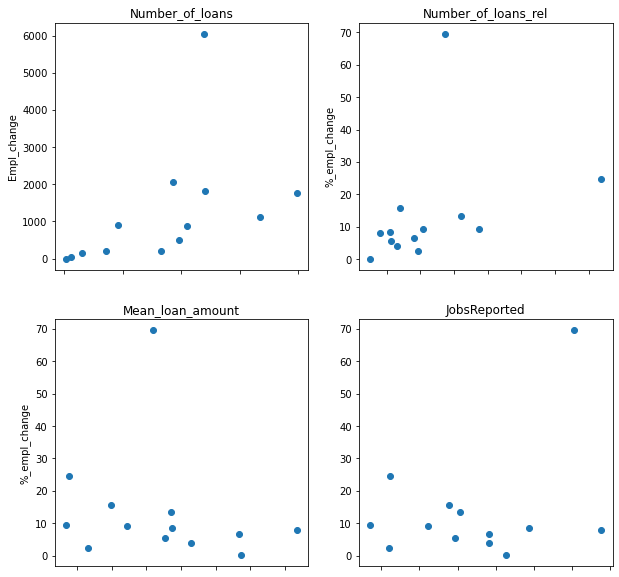

In [57]:
# Plot each predictor vs %_empl_change.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(Industry_grouped['Number_of_loans'], Industry_grouped['Empl_change'])
ax[0, 0].set_title('Number_of_loans')
ax[0, 0].set_ylabel('Empl_change')
ax[0, 0].tick_params(labelbottom=False)
ax[0, 1].scatter(Industry_grouped['Number_of_loans_rel'], Industry_grouped['%_empl_change'])
ax[0, 1].set_title('Number_of_loans_rel')
ax[0, 1].set_ylabel('%_empl_change')
ax[0, 1].tick_params(labelbottom=False)
# ax[0, 1].set_ylim(-2, 30)
ax[1, 0].scatter(Industry_grouped['Mean_loan_amount'], Industry_grouped['%_empl_change'])
ax[1, 0].set_title('Mean_loan_amount')
ax[1, 0].set_ylabel('%_empl_change')
ax[1, 0].tick_params(labelbottom=False)
ax[1, 1].scatter(Industry_grouped['JobsReported'], Industry_grouped['%_empl_change'])
ax[1, 1].set_title('JobsReported')
ax[1, 1].tick_params(labelbottom=False)


Judging by the plots above, each predictor may weakly correlate with the target. Also, there is an outlier: employment growth in Leisure_and_hospitality.

I expect that the total amount of money lent to each industry will correlate with Mean_loan_amount and/or Number_of_loans, and therefore the total lent should be omitted as a feature. But let's have a look first.

In [58]:
PPP_other_features = pd.DataFrame(PPP_df['CurrentApprovalAmount'].groupby([PPP_df['Industry_Type']]).sum())
PPP_other_features.columns = ['Total_lent']
PPP_other_features

,Total_lent
Industry_Type,
Construction,9.816740e+10
Educational_and_health_services,1.134060e+11
Financial_activities,3.830374e+10
Information,1.335984e+10
Leisure_and_hospitality,9.936588e+10
Manufacturing,7.596868e+10
Mining_and_logging,7.538252e+09
Other_services,5.851152e+10
Professional_and_business_services,1.361883e+11


Text(0.5, 1.0, 'Number_of_loans vs. Total_lent')

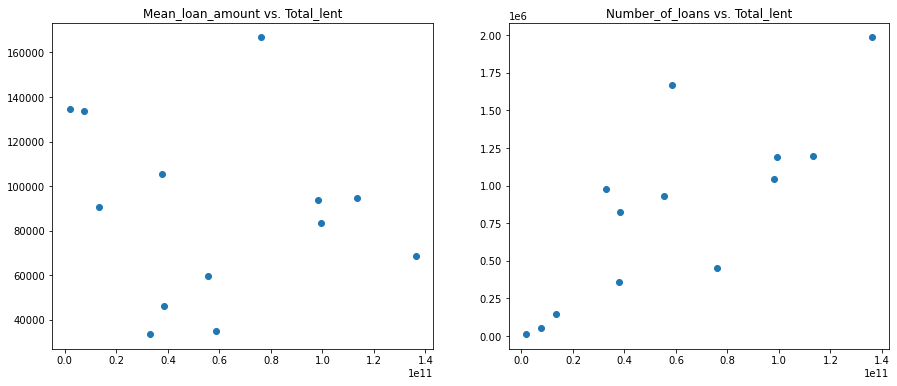

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(PPP_other_features['Total_lent'], Industry_grouped['Mean_loan_amount'])
ax[0].set_title('Mean_loan_amount vs. Total_lent')
ax[1].scatter(PPP_other_features['Total_lent'], Industry_grouped['Number_of_loans'])
ax[1].set_title('Number_of_loans vs. Total_lent')

Number_of_loans and Total_lent do appear correlated, so I will leave out Total_lent. Next I will run some regression models to identify predictors of employment.

In [60]:
# Select predictor columns.
X=Industry_grouped.drop(Industry_grouped.iloc[:, 4:9], axis = 1)
X_abs = X.drop('Number_of_loans_rel', axis = 1)
X_rel = X.drop('Number_of_loans', axis = 1)
X_abs

,Mean_loan_amount,Number_of_loans,JobsReported
Construction,93919.075200,1045240.0,8.104037
Educational_and_health_services,94675.776226,1197841.0,11.745201
Financial_activities,46404.349968,825441.0,4.374639
Information,90699.513983,147298.0,7.847717
Leisure_and_hospitality,83551.752811,1189274.0,14.091540
Manufacturing,166742.611738,455605.0,15.531477
Mining_and_logging,133692.509737,56385.0,9.642086
Other_services,35091.639560,1667397.0,4.442999
Professional_and_business_services,68610.680798,1984950.0,6.454988
Retail_trade,59738.690285,929404.0,7.569503


In [61]:
y_abs = Industry_grouped['Empl_change']
y_rel = Industry_grouped['%_empl_change']
y_abs

Construction                           875.0
Educational_and_health_services       1815.0
Financial_activities                   204.0
Information                            144.0
Leisure_and_hospitality               6043.0
Manufacturing                          904.0
Mining_and_logging                      41.0
Other_services                        1113.0
Professional_and_business_services    1754.0
Retail_trade                          2071.1
Transportation_and_warehousing         490.5
Utilities                                0.8
Wholesale_trade                        216.8
Name: Empl_change, dtype: float64

In [62]:
# Since all columns are numerical, no encoding is required before splitting into train and test subsets.
X_train_abs,X_test_abs,y_train_abs,y_test_abs = train_test_split(X_abs, y_abs, test_size=0.3, random_state=0) 
X_train_rel,X_test_rel,y_train_rel,y_test_rel = train_test_split(X_rel, y_rel, test_size=0.3, random_state=0) 

In [63]:
y_test_abs

Mining_and_logging                  41.0
Utilities                            0.8
Leisure_and_hospitality           6043.0
Transportation_and_warehousing     490.5
Name: Empl_change, dtype: float64

In [64]:
X_train_abs.head()

,Mean_loan_amount,Number_of_loans,JobsReported
Financial_activities,46404.349968,825441.0,4.374639
Professional_and_business_services,68610.680798,1984950.0,6.454988
Educational_and_health_services,94675.776226,1197841.0,11.745201
Other_services,35091.639560,1667397.0,4.442999
Retail_trade,59738.690285,929404.0,7.569503


In [65]:
# Fit and transform X_train_abs, then use fit paramaters from X_train_abs to transform X_test_abs, then convert back to df.
X_train_abs_scaling = scaler.fit_transform(X_train_abs)
X_train_abs = pd.DataFrame(X_train_abs_scaling)
X_train_abs.columns = ['Mean_loan_amount', 'Number_of_loans', 'Jobs_reported']

X_test_abs_scaling = scaler.transform(X_test_abs)
X_test_abs = pd.DataFrame(X_test_abs_scaling).astype('float')
X_test_abs.columns = ['Mean_loan_amount', 'Number_of_loans', 'Jobs_reported']
X_test_abs

,Mean_loan_amount,Number_of_loans,Jobs_reported
0,1.333332,-1.583569,0.368101
1,1.358972,-1.657999,0.643297
2,-0.028685,0.408693,1.700749
3,-1.383312,0.038251,-1.493018


In [66]:
# Do same with X_train_rel.
X_train_rel_scaling = scaler.fit_transform(X_train_rel)
X_train_rel = pd.DataFrame(X_train_rel_scaling)
X_train_rel.columns = ['Mean_loan_amount', 'Number_of_loans_rel', 'Jobs_reported']

X_test_rel_scaling = scaler.transform(X_test_rel)
X_test_rel = pd.DataFrame(X_test_rel_scaling).astype('float')
X_test_rel.columns = ['Mean_loan_amount', 'Number_of_loans_rel', 'Jobs_reported']
X_test_rel

,Mean_loan_amount,Number_of_loans_rel,Jobs_reported
0,1.333332,-0.229211,0.368101
1,1.358972,-0.900533,0.643297
2,-0.028685,0.249447,1.700749
3,-1.383312,0.763645,-1.493018


In [67]:
# Try ElasticNet.
e_net_abs = ElasticNet(random_state=0)
e_net_abs.fit(X_train_abs, y_train_abs)
# predict y to evaluate model
y_predicted_abs_e_net = e_net_abs.predict(X_test_abs)
# calculate RMSE
e_net_abs_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_predicted_abs_e_net, y_test_abs, squared = False)/y_test_abs.mean()*100)
y_predicted_abs_e_net

array([ 463.98295087,  487.42010344, 1455.09819782,  847.42248456])

In [68]:
def evaluate(title, predicted, actual, RMSE):
    plt.scatter(predicted, actual, alpha = 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.figtext(0.15, 0.80, RMSE)

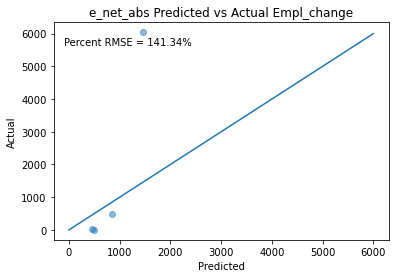

In [69]:
evaluate(title = 'e_net_abs Predicted vs Actual Empl_change', predicted = y_predicted_abs_e_net, actual = y_test_abs, RMSE = e_net_abs_error)
no_error_x = (0, 6000)
no_error_y = (0, 6000)
plt.plot(no_error_x, no_error_y)

The model did a better job predicting three of the four actuals in the test set. The fourth actual must be 'Leisure_and_hospitality', judging by its actual Empl_change. What is RMSE with this industry removed? 

In [70]:
y_test_abs_trim = y_test_abs.drop('Leisure_and_hospitality')
# Since X_test lost index labels during scaling, drop this row by its index position.
X_test_abs_trim = X_test_abs.drop(X_test_abs.index[2])
y_pred_abs_trim_e_net = e_net_abs.predict(X_test_abs_trim)
RMSE_abs_trim_e_net = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_pred_abs_trim_e_net, y_test_abs_trim, squared = False)/y_test_abs_trim.mean()*100)
RMSE_abs_trim_e_net

'Percent RMSE = 239.80%'

What effect does scaling number of loans and employment change by Empl_avg have on model performance?

In [71]:
e_net_rel = ElasticNet(random_state=0)
e_net_rel.fit(X_train_rel, y_train_rel)
# predict y to evaluate model
y_predicted_rel_e_net = e_net_rel.predict(X_test_rel)
# calculate RMSE
e_net_rel_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_predicted_rel_e_net, y_test_rel, squared = False)/y_test_rel.mean()*100)

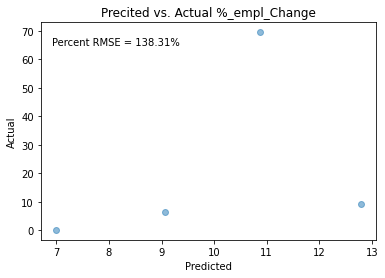

In [72]:
evaluate(title = 'Precited vs. Actual %_empl_Change', predicted = y_predicted_rel_e_net, actual = y_test_rel, RMSE = e_net_rel_error)

What is RMSE with Leisure_and_hospitality removed? 

In [73]:
y_test_rel_trim = y_test_rel.drop('Leisure_and_hospitality')
# Since X_test lost index labels during scaling, drop this row by its index position.
X_test_rel_trim = X_test_rel.drop(X_test_rel.index[2])

In [74]:
# Predict target
y_pred_rel_trim_e_net = e_net_rel.predict(X_test_rel_trim)
RMSE_rel_trim_e_net = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_pred_rel_trim_e_net, y_test_rel_trim, squared = False)/y_test_rel_trim.mean()*100)
RMSE_rel_trim_e_net

'Percent RMSE = 86.74%'

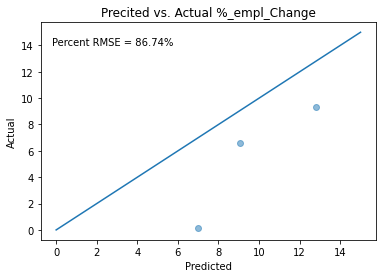

In [75]:
evaluate(title = 'Precited vs. Actual %_empl_Change', predicted = y_pred_rel_trim_e_net, actual = y_test_rel_trim, RMSE = RMSE_rel_trim_e_net)
no_error_x = (0, 15)
no_error_y = (0, 15)
plt.plot(no_error_x, no_error_y)

Scaling the number of loans and employment change to industry size did reduce percent RMSE quite a bit, but there is still a large amount of error. The predictions for each of these three industries was high.

In [76]:
# What are the coefficients?
elastic_net_coefs = pd.DataFrame(e_net_rel.coef_)
elastic_net_coefs['Predictor'] = ['Mean_loan_amount', 'Number_of_loans', 'Jobs_reported']
elastic_net_coefs.set_index(['Predictor'], inplace = True)
elastic_net_coefs.columns = ['e_net Coefficient']
elastic_net_coefs

,e_net Coefficient
Predictor,
Mean_loan_amount,-0.238459
Number_of_loans,3.085542
Jobs_reported,0.000000


Does cross validation improve accuracy of ElasticNet?

In [77]:
e_netCV = ElasticNetCV(cv = 3)
e_netCV.fit(X_train_rel, y_train_rel)
# predict y to evaluate model
y_predicted_e_netCV = e_netCV.predict(X_test_rel)
# calculate RMSE
e_netCV_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_predicted_e_netCV, y_test_rel, squared = False)/y_test_rel.mean()*100)

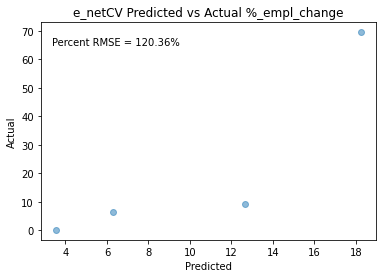

In [78]:
evaluate(title = 'e_netCV Predicted vs Actual %_empl_change', predicted = y_predicted_e_netCV, actual = y_test_rel, RMSE = e_netCV_error)

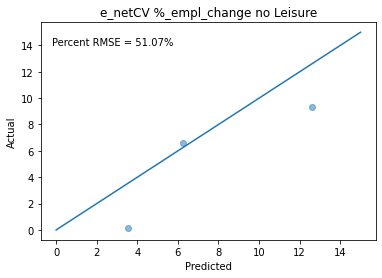

In [79]:
y_pred_trim_e_netCV = e_netCV.predict(X_test_rel_trim)
e_netCV_trim_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_pred_trim_e_netCV, y_test_rel_trim, squared = False)/y_test_rel_trim.mean()*100)
evaluate(title = 'e_netCV %_empl_change no Leisure', predicted = y_pred_trim_e_netCV, actual = y_test_rel_trim, RMSE = e_netCV_trim_error)
no_error_x = (0, 15)
no_error_y = (0, 15)
plt.plot(no_error_x, no_error_y)

In [80]:
# Try Random Forest
RFregr = RandomForestRegressor(random_state=0)
RFregr.fit(X_train_rel, y_train_rel)

RandomForestRegressor(random_state=0)

In [81]:
# predict y to evaluate model 
y_predicted_RFregr = RFregr.predict(X_test_rel)
# calculate RMSE
RFregr_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_predicted_RFregr, y_test_rel, squared = False)/y_test_rel.mean()*100)

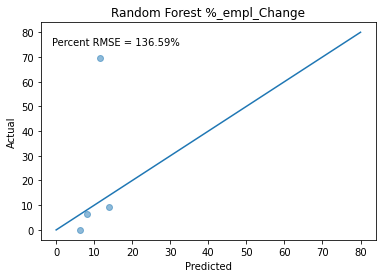

In [82]:
evaluate(title = 'Random Forest %_empl_Change', predicted = y_predicted_RFregr, actual = y_test_rel, RMSE = RFregr_error)
no_error_x = (0, 80)
no_error_y = (0, 80)
plt.plot(no_error_x, no_error_y)

In [83]:
# Calculate RMSE with 'Leisure_and_hospitality' removed.
y_predicted_trim_RFregr = RFregr.predict(X_test_rel_trim)
# calculate RMSE
RMSE_RFregr_trim_error = 'Percent RMSE = {:.2f}%'.format(mean_squared_error(y_predicted_trim_RFregr, y_test_rel_trim, squared = False)/y_test_rel_trim.mean()*100)

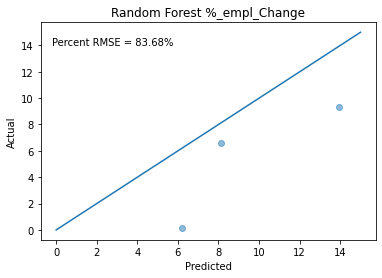

In [84]:
evaluate(title = 'Random Forest %_empl_Change', predicted = y_predicted_trim_RFregr, actual = y_test_rel_trim, RMSE = RMSE_RFregr_trim_error)
no_error_x = (0, 15)
no_error_y = (0, 15)
plt.plot(no_error_x, no_error_y)

What are the coefficients in the ElasticNetCV model?

In [85]:
elastic_netCV_coefs = pd.DataFrame(e_netCV.coef_)
elastic_netCV_coefs['Predictor'] = ['Mean_loan_amount', 'Number_of_loans', 'Jobs_reported']
elastic_netCV_coefs.set_index(['Predictor'], inplace = True)
elastic_netCV_coefs.columns = ['e_netCV Coefficient']
elastic_netCV_coefs

,e_netCV Coefficient
Predictor,
Mean_loan_amount,-2.996408
Number_of_loans,5.546383
Jobs_reported,3.915761


In [86]:
RFregr.feature_importances_

array([0.43586879, 0.41203907, 0.15209214])

Random Forest feature importance identifies loan size and number of loans as more informative than business size.

Not surprisingly, error was very high for all models (lowest Percent RMSE = 51.07%), indicating that any emerging trends are very tentative. If one were tempted to interpret the models, considered together they suggest that growth in employment may be positively correlated with the number of loans and possibly business size, and be negatively correlated with loan size.